In [3]:
import numpy as np
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt
import pickle

from utils import create_vectors, encode_point
from region_query_utils import direction_quad, saccades, lookup_space_table, predict_single_query
from region_query_utils import predict_single_query, get_quads, generate_space_table

from region_query_utils import generate_rectangle_region


from image_to_memory import encode_memory_shape, decode_image

#putting it all together

In [5]:
objs = ["ZERO", "ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX", "SEVEN", "EIGHT", "NINE"]
D = 512

n = 1000 #number of images
m = 4 #digits per image (max 4 right now due to spread factor)

from mnist_image_generator import gen_images
image_data = gen_images(n,m)

xs_original = np.array(image_data['x'])
ys_original = np.array(image_data['y'])

#get direction of second object towards first object
dirs = direction_quad(xs_original[:, 0] - xs_original[:, 1], ys_original[:, 0] - ys_original[:, 1])

xs, ys = saccades(image_data['images'])
xs = np.array(xs)
ys = np.array(ys)

import keras

im_dim = 28
model = keras.models.load_model('mnist_net.h5')

pred_obj_list = decode_image(image_data['images'], xs, ys, im_dim//2, model)

accuracy =[]
for i in range(100):
    obj_dic, vec_dic = create_vectors(objs, D)
    X = vec_dic['X']
    Y = vec_dic['Y']

    obj_vectors = np.array([obj_dic[_] for _ in objs])

    square = generate_rectangle_region([-1,1],[-1,1], X,Y)
    square.normalized()

    #store objects in memory as squares rather than points
    memory_data = encode_memory_shape(pred_obj_list, xs,ys, obj_vectors, [X,Y], square, n, m)
    # memory_data = encode_memory(pred_obj_list, xs,ys, obj_vectors, [X,Y], n, m)

    UP_RIGHT, DOWN_RIGHT, UP_LEFT, DOWN_LEFT = get_quads(X,Y, 5)
    region_selector = np.array([[DOWN_LEFT, UP_LEFT],[DOWN_RIGHT, UP_RIGHT]])

    loc_table = generate_space_table(np.linspace(-5, 5, 100),np.linspace(-5, 5, 100),D, X,Y)

    obj_list = np.array(image_data['obj_list'])
    query_obj = [obj_dic[objs[o]] for o in obj_list[:,1]]

    preds = predict_single_query(memory_data['obj_loc_memory'], memory_data['obj_memory'], query_obj, dirs, obj_dic, region_selector, loc_table)

    #Check if the predicted vector is in the correct direction (since multiple correct answers)

    inregion_map = np.zeros((n, m))
    for i in range(m):
        correct_dir_1 = np.all(np.array(dirs) == np.array(direction_quad(xs_original[:, i] - xs_original[:, 1], ys_original[:, i] - ys_original[:, 1])), axis=0)

        inregion_map[:,i] = correct_dir_1

    inregion = np.where(inregion_map, obj_list, -1)

    accuracy.append(np.mean(np.any((inregion== preds[:,None]), axis = 1)))

print(np.mean(accuracy))

0.81742


In [11]:
np.where(np.any((inregion== preds[:,None]), axis = 1) == 0)

(array([  2,   4,   5,  11,  22,  33,  36,  38,  44,  45,  48,  50,  52,
         61,  62,  64,  65,  73,  74,  77,  78,  79,  80,  81,  87,  92,
         94, 101, 106, 111, 114, 115, 121, 122, 130, 135, 136, 139, 140,
        143, 144, 152, 155, 163, 164, 170, 171, 173, 178, 186, 187, 191,
        193, 197, 200, 202, 210, 217, 219, 221, 229, 235, 244, 246, 256,
        267, 269, 274, 276, 278, 288, 294, 299, 301, 304, 310, 315, 318,
        319, 327, 329, 336, 338, 343, 349, 353, 357, 364, 370, 374, 375,
        376, 381, 389, 399, 400, 401, 405, 408, 409, 411, 415, 416, 420,
        424, 430, 431, 439, 440, 443, 444, 450, 451, 454, 455, 459, 462,
        465, 469, 470, 471, 474, 484, 497, 500, 504, 505, 506, 519, 520,
        528, 531, 533, 534, 535, 537, 540, 543, 546, 554, 558, 561, 566,
        571, 574, 586, 588, 590, 593, 597, 601, 602, 612, 619, 620, 625,
        630, 631, 633, 635, 640, 642, 646, 647, 655, 658, 659, 664, 679,
        685, 687, 691, 693, 697, 702, 708, 712, 714

In [16]:
i= 2
[obj_list[i], preds[i]]

[array([4, 6, 1, 7], dtype=uint8), 1]

In [20]:
[d[i] for d in dirs]

[1, 0]

In [124]:
obj_dic.dot(memory_data['obj_loc_memory'][i] * ~ ((spa.SemanticPointer(loc) * region_selector[1,0])).normalized())

array([-0.04931587, -0.26430457,  0.15903949, -0.30961109,  1.50777309,
       -0.0029921 , -0.12039565,  0.01652365, -0.42643372,  0.15774025])

In [126]:
spa.SemanticPointer(loc4).dot((spa.SemanticPointer(loc) * region_selector[1,0]))

1.0762595513898598

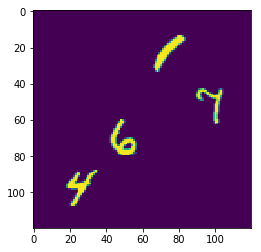

In [13]:
plt.imshow(image_data['images'][i])

In [70]:
from utils import spatial_dot
from region_query_utils import lookup_space_table, generate_rectangle_region

In [73]:
def generate_rectangle_region_old(x_range, y_range, X, Y, resolution = 100):
    fft_X = np.fft.fft(X.v)
    fft_Y = np.fft.fft(Y.v)

    phi = np.angle(fft_X)
    gamma = np.angle(fft_Y)
    assert np.allclose(np.abs(fft_X), 1)
    assert np.allclose(np.abs(fft_Y), 1)
    if any(phi == 0):
        # can't divide, just use summation
        region_analytic = np.zeros_like(X.v)
        for x in np.linspace(*x_range, resolution):
            for y in np.linspace(*y_range, resolution):
                region_analytic += encode_point(x, y, X, Y).v
        return spa.SemanticPointer(region_analytic/np.max(spatial_dot(region_analytic, np.linspace(*x_range,resolution/5), np.linspace(*y_range,resolution/5),X, Y)))
    else:
        # (FYI this is Euler's formula as we are applying it implicitly)
        # pi = phi * x1
        # assert np.allclose(fft_X ** x1, np.cos(pi) + 1j * np.sin(pi))
        INVPHI = spa.SemanticPointer(np.fft.ifft(1j / phi))
        INVGAMMA = spa.SemanticPointer(np.fft.ifft(1j / gamma))

        region_algebraic = (((power(X, x_range[1]) - power(X, x_range[0])) * INVPHI) *
                            (((power(Y, y_range[1]) - power(Y, y_range[0])) * INVGAMMA)))
        return region_algebraic

array([ 0.04207248,  0.04665995,  0.00371468, -0.01813521, -0.06565696,
        0.02084894,  0.03324308,  0.0963752 , -0.01688296, -0.04678506,
       -0.00764444, -0.04031352, -0.00923667, -0.03228025, -0.0606662 ,
        0.07646712, -0.00579649,  0.00327419, -0.01755412,  0.02445479,
        0.11926043, -0.00667953, -0.02991528, -0.05716556, -0.01851603,
        0.03006643,  0.05136116, -0.05413561, -0.04476116,  0.06303338,
        0.05509422,  0.02742768, -0.05692485,  0.03171029,  0.02061201,
       -0.05975624,  0.01714448,  0.028797  , -0.01445298,  0.03285403,
       -0.11277361,  0.02632497, -0.00998463,  0.0155907 ,  0.0547421 ,
       -0.01860251,  0.01219151,  0.0054394 ,  0.06828144,  0.03651835,
        0.09324386, -0.04544303,  0.02386198,  0.04042323,  0.01872655,
       -0.03409497,  0.00944507, -0.032424  ,  0.02322347, -0.00841074,
       -0.01913294, -0.01943294, -0.11003383,  0.06104025,  0.01105871,
        0.07685654, -0.03966507,  0.00608772,  0.03029238, -0.03